In [1]:
import sys
import os
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import detrend
from scipy.stats import spearmanr
from pathlib import Path

In [2]:
sys.path.append(os.path.expanduser('~/Documents/Hybrid/'))
from Hybrid.dataloading import prepare_full_set, read_tganom_predictand
from Hybrid.dataprep import test_trainval_split, filter_predictor_set, j_measure, perkins

sys.path.append(os.path.expanduser('~/Documents/Weave/'))
from Weave.utils import collapse_restore_multiindex

2022-01-04 12:42:03.729696: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-04 12:42:03.729718: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
#leadtimepool = [4,5,6,7,8]
def compute_imps(targetname, leadtimepool, ndaythreshold = 7, tganomkwargs = {}, with_gmst = True):
    """ Returns j_measures and 1-p_measures compute on the trainval set 
    tganomkwargs should contain booksname, climname, modelclimname
    """
    target_region = 9
    predictors, forc, obs = prepare_full_set(targetname, ndaythreshold = ndaythreshold, predictand_cluster = target_region, leadtimepool = leadtimepool)
    _, obs_trainval, _ = test_trainval_split(obs, crossval = True, nfolds = 3, balanced = True)
    _, pred_trainval, _ = test_trainval_split(predictors, crossval = True, nfolds = 3, balanced = True)
    if tganomkwargs:
        obs_trainval, _ = read_tganom_predictand(clustid = target_region, separation = leadtimepool, **tganomkwargs)
        obs_trainval = obs_trainval.loc[pred_trainval.index,:]
    # Test what a trend variable does. Not a trend in probability
    # So perhaps just global mean surface temperature?
    if with_gmst:
        trend_path = '/nobackup/users/straaten/predsets/tg_monthly_global_mean_surface_only_trend.nc'
        trend = xr.open_dataarray(trend_path).to_dataframe()
        trend.columns = pd.MultiIndex.from_tuples([('tg-anom',31,0,'mean')], names = pred_trainval.columns.names)
        pred_trainval = pred_trainval.join(trend, how = 'left')
    _, js = filter_predictor_set(pred_trainval, obs_trainval.iloc[:,-1].astype(bool), how = j_measure, return_measures = True, nmost_important = 1, nbins=10)
    _, ps = filter_predictor_set(pred_trainval, obs_trainval.iloc[:,-1].astype(bool), how = perkins, return_measures = True, nmost_important = 1, nbins = 10)
    oneminps = 1 - ps
    oneminps.name = f'1-{ps.name}'
    return pd.concat([js, oneminps], axis = 1)

def load_sequential_imps(name: str, npreds: int = None):
    """
    Loads the sequential forward importances. (Ranks)
    can be single (lots of predictors) or multi (only n_depth of predictors)
    you can supply the total number of predictors (not inferable from size of the multi file)
    """
    basepath = Path('/nobackup/users/straaten/predsets/objective_balanced_cv/')
    temp = pd.read_csv(basepath / f'{name}.csv', index_col = 0, header = 0)
    collapse_restore_multiindex(temp, axis = 1, names = ['variable','timeagg','clustid','metric'], dtypes = [str,int,int,str], inplace = True)
    if (npreds is None):
        npreds = len(temp.columns)
    ranks = npreds - temp.loc['rank']
    return ranks
    
def scatter(df, xcol, ycol, n_names = 10, title: str = None):
    """
    Plots two columns of the dataframe (potentially sorted) against each other
    names the bottom n_names rows by their index value
    """
    fig, ax = plt.subplots()
    ax.scatter(x = df[xcol], y = df[ycol], alpha = 0.3)
    try: 
        trendpoint = df.loc[('tg-anom',31,0,'mean'),:]
        ax.scatter(x = trendpoint.loc[xcol], y = trendpoint.loc[ycol], color = 'red')
    except KeyError:
        pass
    for i in range(n_names):
        #ax.text(x = df[xcol].iloc[-i], y = df[ycol].iloc[-i], s = str(df.index[-i]))
        ax.annotate(str(df.index[i]), xy = (df[xcol].iloc[i],df[ycol].iloc[i]), xycoords = 'data',
                    xytext=(1.05,np.linspace(1,0,num=n_names)[i]), textcoords='axes fraction',
                   arrowprops=dict(color='grey', shrink=0.01, width = 0.2, headwidth = 0.8, zorder = 0))
    ax.set_xlabel(xcol)
    ax.set_ylabel(ycol)
    if not (title is None):
        ax.set_title(title)
    return fig, ax

## Leadtime 19-21

In [57]:
# First the non-sequential importances (potentially influenced by trends)
tgex7 = compute_imps(targetname = 'books_paper3-2_tg-ex-q0.75-21D_JJA_45r1_1D_15-t2m-q095-adapted-mean.csv', leadtimepool = list(range(19,22)))
tgex4 = compute_imps(targetname = 'books_paper3-2_tg-ex-q0.75-21D_JJA_45r1_1D_15-t2m-q095-adapted-mean.csv', ndaythreshold= 4, leadtimepool = list(range(19,22)))
tganomkwargs = dict(booksname = 'books_paper3-1_tg-anom_JJA_45r1_21D-roll-mean_15-t2m-q095-adapted-mean.csv',climname = 'tg-anom_clim_1998-06-07_2019-10-31_21D-roll-mean_15-t2m-q095-adapted-mean_15_15_q0.5', modelclimname = 'tg-anom_45r1_1998-06-07_2019-08-31_21D-roll-mean_15-t2m-q095-adapted-mean_15_15_q0.5')
tganom21 = compute_imps(targetname = 'books_paper3-2_tg-ex-q0.75-21D_JJA_45r1_1D_15-t2m-q095-adapted-mean.csv', leadtimepool = list(range(19,22)), tganomkwargs = tganomkwargs)
# Now the sequential stepwise importances.
# CURRENTLY NOT the fully projected timeseries.
tgex7_single = load_sequential_imps(name = 'emp_duplicated/tg-ex-q0.75-21D_ge7D_sep19-21_single_d20_b3')
tgex7_multi = load_sequential_imps(name = 'emp_duplicated/tg-ex-q0.75-21D_ge7D_sep19-21_multi_d20_b3', npreds = len(tgex7_single))

/usr/people/straaten/Documents/Hybrid/Hybrid/dataloading.py:204: UserWarning: picking values from pattern at 21 which got projected onto the shorter leadtimes in [19, 20, 21]
  warnings.warn(f'picking values from pattern at {longest_shared_leadtime} which got projected onto the shorter leadtimes in {leadtimepool}')


Binarized target: n_hotdays >= 7, onehot-encoded


/usr/people/straaten/Documents/Hybrid/Hybrid/dataprep.py:40: UserWarning: using alpha 0.3333333333333333 for forecast categorization
  warnings.warn(f'using alpha {alpha} for forecast categorization')
/usr/people/straaten/Documents/Hybrid/Hybrid/dataloading.py:204: UserWarning: picking values from pattern at 21 which got projected onto the shorter leadtimes in [19, 20, 21]
  warnings.warn(f'picking values from pattern at {longest_shared_leadtime} which got projected onto the shorter leadtimes in {leadtimepool}')


Binarized target: n_hotdays >= 4, onehot-encoded


/usr/people/straaten/Documents/Hybrid/Hybrid/dataprep.py:40: UserWarning: using alpha 0.3333333333333333 for forecast categorization
  warnings.warn(f'using alpha {alpha} for forecast categorization')
/usr/people/straaten/Documents/Hybrid/Hybrid/dataloading.py:204: UserWarning: picking values from pattern at 21 which got projected onto the shorter leadtimes in [19, 20, 21]
  warnings.warn(f'picking values from pattern at {longest_shared_leadtime} which got projected onto the shorter leadtimes in {leadtimepool}')


Binarized target: n_hotdays >= 7, onehot-encoded
climatology directly loaded
climatology directly loaded


/usr/people/straaten/Documents/Hybrid/Hybrid/dataprep.py:40: UserWarning: using alpha 0.3333333333333333 for forecast categorization
  warnings.warn(f'using alpha {alpha} for forecast categorization')
/nobackup_1/users/straaten/DLVENV/lib64/python3.9/site-packages/pandas/core/generic.py:4147: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


lazy pi and bool observation construction


In [16]:
# All combined.
lead1921 = pd.concat([tgex7,tgex4,tganom21, tgex7_multi, tgex7_single], axis = 1, keys = ['tgex7','tgex4','tganom21','tgex7_multi','tgex7_single'])

### j_measure vs perkins
high correspondence between measures. Trend is prominent in both, perhaps a bit more so in perkins

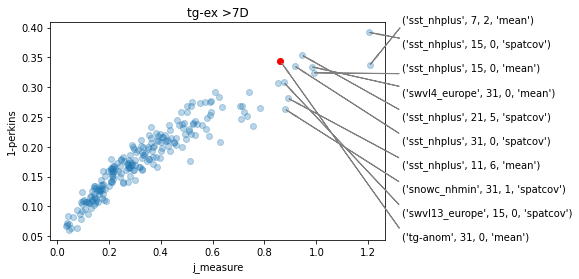

In [64]:
df = lead1921['tgex7']
scatter(df.sort_values('j_measure', ascending = False), xcol = 'j_measure', ycol = '1-perkins', title = 'tg-ex >7D')
plt.show()

In [65]:
def cormatrix(no_missing: pd.DataFrame, title = ''):
    fig, ax = plt.subplots()
    im = ax.imshow(spearmanr(no_missing.values, axis = 0)[0], vmin = 0, vmax = 1)

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(no_missing.columns)))
    ax.set_xticklabels(no_missing.columns.to_flat_index().values)
    ax.set_yticks(np.arange(len(no_missing.columns)))
    ax.set_yticklabels(no_missing.columns.to_flat_index().values)
    ax.set_title(title)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    return fig, ax

df_allvars = lead1921.drop('tgex7_multi', axis = 1).dropna(how = 'any') # Drops the tg-anom 31 and z-reg 21 -1
cormatrix(df_allvars, title = 'correlation in all vars')
plt.show()
df_20vars = lead1921.dropna(how = 'any')
cormatrix(df_20vars, title = 'correlation in 20 most important vars')
plt.show()

NameError: name 'lead1921' is not defined

Although the latter matrix with correlation is more noisy (only 20 samples). We do see that singlepass gets more agreeable with the other rankings than when the whole set is evaluated. In the small set, it is multipass that disagrees the most with the measures and of those it disagrees most with tg-anom. This confirms that it seems to be selecting a different set.

### singlepass and multipass vs j_measure
Are combinations surprising, are at least the top predictors retained?

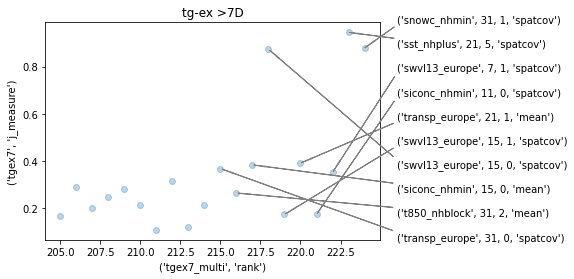

In [65]:
scatter(lead1921.sort_values(('tgex7_multi','rank'), ascending = False), xcol = ('tgex7_multi','rank'), ycol = ('tgex7','j_measure'), 
        title = 'tg-ex >7D: multipass selection')
plt.show()

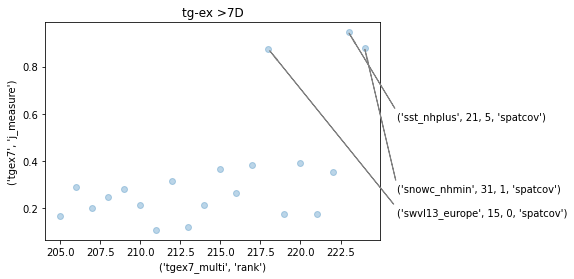

In [66]:
scatter(lead1921.sort_values(('tgex7','j_measure'), ascending = False), xcol = ('tgex7_multi','rank'), ycol = ('tgex7','j_measure'), 
        title = 'tg-ex >7D: j_measure selection')
plt.show()

We see that only three predictors are retained by multipass. All others included by multipass are actually low in the ranking by j_measure. Unfortunately these are not the three top predictors in multipass (such that we can cutoff the search). Lets look at singlepass.

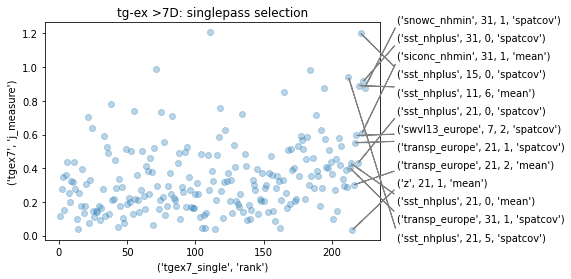

In [73]:
scatter(lead1921.sort_values(('tgex7_single','rank'), ascending = False), xcol = ('tgex7_single','rank'), ycol = ('tgex7','j_measure'), 
        title = 'tg-ex >7D: singlepass selection', n_names = 13)
plt.show()

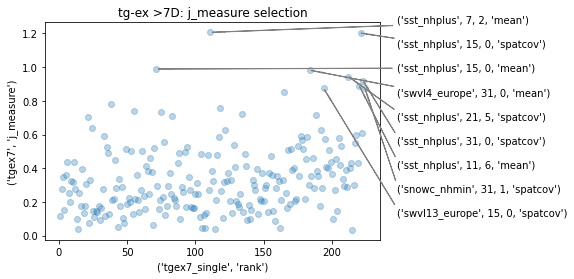

In [70]:
scatter(lead1921.sort_values(('tgex7','j_measure'), ascending = False), xcol = ('tgex7_single','rank'), ycol = ('tgex7','j_measure'), 
        title = 'tg-ex >7D: j_measure selection')
plt.show()

Singlepass includes a predictor that belongs to the lowest of j-measures. The converse is not true for the j_measure set (in the top three it does include 2 mean predictors that are not very important according singlepass).
Bit worrying is that singlepass misses a known top predictor (sst_nhplus,21,5,spatcov) in its top 10 (only as 13th).

### tganom vs tg-ex in terms of j_measure
tganom provides sets that differ the most from multipass selections. Are combinations surprising, are at least the top predictors retained?

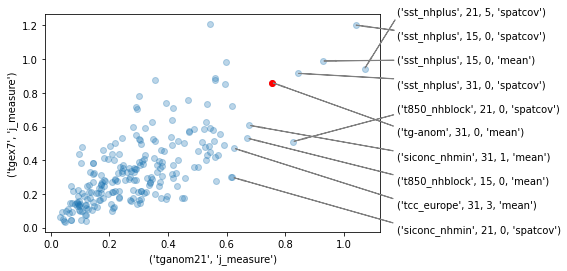

In [76]:
scatter(lead1921.sort_values(('tganom21','j_measure'), ascending = False), xcol = ('tganom21','j_measure'), ycol = ('tgex7','j_measure'))
plt.show()

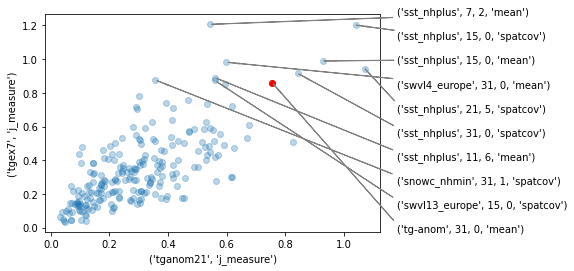

In [75]:
scatter(lead1921.sort_values(('tgex7','j_measure'), ascending = False), xcol = ('tganom21','j_measure'), ycol = ('tgex7','j_measure'))
plt.show()

Tg-anom seems to miss the snowcover predictor (eurasian one). which was actually top for tg-ex + j-measure and definitely top for tg-ex + stepwise selection.

In all combinations above the amount of spatcov features > mean features

# Leadtime 12-15
Has potentially better skill, meaning that singlepass and multipass forward could be more meaningful. But has also been prone to overfitting.

Also stepwise multipass selection for tg-anom is available, and has been computed with a simpler model (depth = 1, epochs = 40, patience = 7). This led to the 'accidental good result'.
Question is: is that set more like the j-measure sets? Or is singlepass in that case more like multipass?

In [59]:
# First the non-sequential importances (potentially influenced by trends)
tgex7 = compute_imps(targetname = 'books_paper3-2_tg-ex-q0.75-21D_JJA_45r1_1D_15-t2m-q095-adapted-mean.csv', leadtimepool = list(range(12,16)))
tganomkwargs = dict(booksname = 'books_paper3-1_tg-anom_JJA_45r1_31D-roll-mean_15-t2m-q095-adapted-mean.csv',climname = 'tg-anom_clim_1998-06-07_2019-10-31_31D-roll-mean_15-t2m-q095-adapted-mean_15_15_q0.5', modelclimname = 'tg-anom_45r1_1998-06-07_2019-08-31_31D-roll-mean_15-t2m-q095-adapted-mean_15_15_q0.5')
tganom31 = compute_imps(targetname = 'books_paper3-2_tg-ex-q0.75-21D_JJA_45r1_1D_15-t2m-q095-adapted-mean.csv', leadtimepool = list(range(12,16)), tganomkwargs = tganomkwargs)
# Now the sequential stepwise importances:
# CURRENTLY NOT the fully projected timeseries.
tgex7_single = load_sequential_imps(name = 'tg-ex-q0.75-21D_ge7D_sep12-15_single_d20_b3')
tgex7_multi = load_sequential_imps(name = 'tg-ex-q0.75-21D_ge7D_sep12-15_multi_d20_b3', npreds = len(tgex7_single))
tganom31_single = load_sequential_imps(name = 'tg-anom_JJA_45r1_31D-roll-mean_q0.5_sep12-15_single_d20_b3')
tganom31_multi = load_sequential_imps(name = 'tg-anom_JJA_45r1_31D-roll-mean_q0.5_sep12-15_multi_d20_b3', npreds = len(tganom31_single))

/usr/people/straaten/Documents/Hybrid/Hybrid/dataloading.py:204: UserWarning: picking values from pattern at 15 which got projected onto the shorter leadtimes in [12, 13, 14, 15]
  warnings.warn(f'picking values from pattern at {longest_shared_leadtime} which got projected onto the shorter leadtimes in {leadtimepool}')


Binarized target: n_hotdays >= 7, onehot-encoded


/usr/people/straaten/Documents/Hybrid/Hybrid/dataprep.py:40: UserWarning: using alpha 0.3333333333333333 for forecast categorization
  warnings.warn(f'using alpha {alpha} for forecast categorization')
/usr/people/straaten/Documents/Hybrid/Hybrid/dataloading.py:204: UserWarning: picking values from pattern at 15 which got projected onto the shorter leadtimes in [12, 13, 14, 15]
  warnings.warn(f'picking values from pattern at {longest_shared_leadtime} which got projected onto the shorter leadtimes in {leadtimepool}')


Binarized target: n_hotdays >= 7, onehot-encoded
climatology directly loaded
climatology directly loaded
lazy pi and bool observation construction


/usr/people/straaten/Documents/Hybrid/Hybrid/dataprep.py:40: UserWarning: using alpha 0.3333333333333333 for forecast categorization
  warnings.warn(f'using alpha {alpha} for forecast categorization')
/nobackup_1/users/straaten/DLVENV/lib64/python3.9/site-packages/pandas/core/generic.py:4147: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [61]:
# All combined.tganom31_simple_multi has the most nans because only 15 most important.
lead1215 = pd.concat([tgex7, tganom31, tgex7_single, tgex7_multi, tganom31_single, tganom31_multi ], axis = 1, 
                     keys = ['tgex7', 'tganom31', 'tgex7_single', 'tgex7_multi', 'tganom31_single', 'tganom31_multi'])

In [62]:
lead1215.isnull().sum(axis = 0)

tgex7            j_measure      0
                 1-perkins      0
tganom31         j_measure      0
                 1-perkins      0
tgex7_single     rank           2
tgex7_multi      rank         218
tganom31_single  rank           2
tganom31_multi   rank         218
dtype: int64

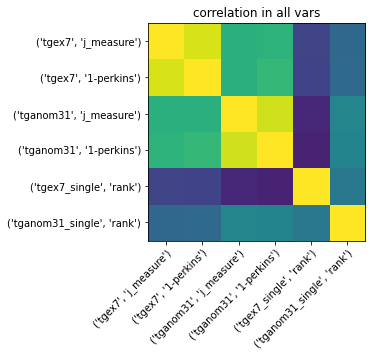

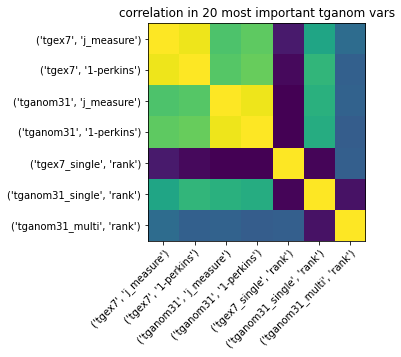

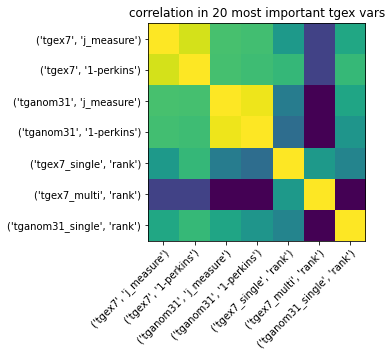

In [67]:
df_allvars = lead1215.drop(['tgex7_multi','tganom31_multi'], axis = 1).dropna(how = 'any') # Drops the tg-anom 31 and z-reg 21 -1
cormatrix(df_allvars, title = 'correlation in all vars')
plt.show()
df_15vars = lead1215.drop(['tgex7_multi'], axis = 1).dropna(how = 'any')
cormatrix(df_15vars, title = 'correlation in 20 most important tganom vars')
plt.show()
df_20vars = lead1215.drop(['tganom31_multi'], axis = 1).dropna(how = 'any')
cormatrix(df_20vars, title = 'correlation in 20 most important tgex vars')
plt.show()

* The single selection set of tgex7 and tg-anom31 do not corrspond well. 
* The simple tganom31 multiset corresponds better to the tgex7 j-measure than the tgex7 multiset itself. In correspondance to tganom31 j-measure they seem equal.

### Shallow multipass vs tg-ex7 and deeper multipass vs tg-ex7

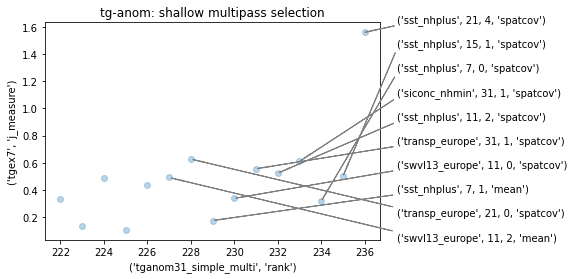

In [96]:
scatter(lead1215.sort_values(('tganom31_simple_multi','rank'), ascending = False), xcol = ('tganom31_simple_multi','rank',), ycol = ('tgex7','j_measure'), 
        title = 'tg-anom: shallow multipass selection')
plt.show()

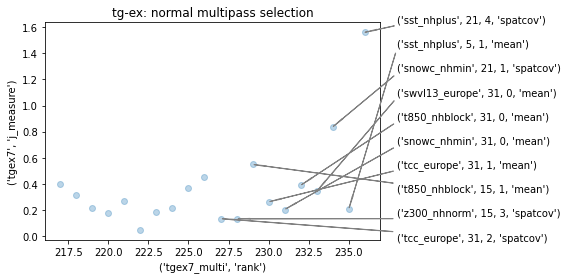

In [97]:
scatter(lead1215.sort_values(('tgex7_multi','rank'), ascending = False), xcol = ('tgex7_multi','rank',), ycol = ('tgex7','j_measure'), 
        title = 'tg-ex: normal multipass selection')
plt.show()

* tganom + simple selects for much more spatcovs than tg-ex. Is that due to the shallowness or due to the fact of tg-anom?
* tg-ex multipass has more predictors below the 0.4 j-measure importance. 

### Tg-anom vs Tg-ex in j-measure

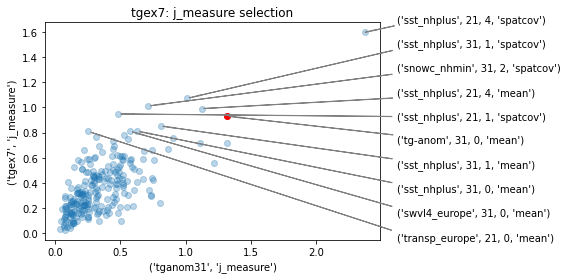

In [68]:
scatter(lead1215.sort_values(('tgex7','j_measure'), ascending = False), xcol = ('tganom31','j_measure'), ycol = ('tgex7','j_measure'), 
        title = 'tgex7: j_measure selection')
plt.show()

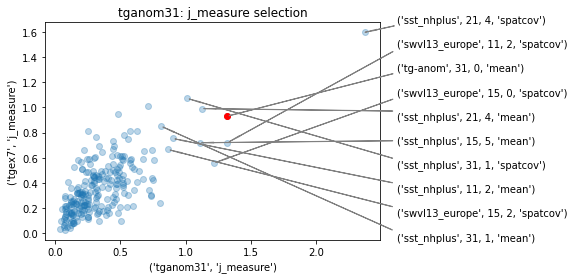

In [69]:
scatter(lead1215.sort_values(('tganom31','j_measure'), ascending = False), xcol = ('tganom31','j_measure'), ycol = ('tgex7','j_measure'), 
        title = 'tganom31: j_measure selection')
plt.show()

* Both have the same top two predictors. the gmst is very prominent. sst_nhplus 21.4 is selected with both mean and spatcov.
* the amount of means selected for is more or less equal (4 vs 5) this gives the hint that the higher amount of multipass spatcovs might be due to the shallowness.
* swvl13 is completely lacking in tg-ex. But tg-ex7 does have swvl4

## Leadtime 12-15, full spatcov projections
New series with continuous projection instead of duplication. The real benefit will probably occur when more leadtimes are pooled. E.g. 11-15. 
Current selections for:
* tganom31 > q0.75
* tganom31 > q0.5
* tganom21 > q0.75
* tganom21 > q0.5
* tgex7
* tgex5

OLD Shared predictors in the top 15 (tganom21, tgex5, tgex7):
* sst_nhplus.21.4.spatcov (west pacific)
* sst_nhplus.5.1.mean (atlantic and ostzee)
* z.21.[1,2].mean
* t850_nhblock.21.0.mean (only the +- median targets, tropical belt + sahel + indian ocean)
* t850_nhblock.15.1.[spatcov,mean] (only the west sahel banana)
* snowc_nhmin.21.1.spatcov (only the tg-exes, east eurasia)

NEW Shared predictors (non-noisy predictands). But with 6 sets not a lot is truly shared (same extremity shares more, and tg and tg-ex among themselves share more).
* 'sst_nhplus', 21, 4, 'spatcov'
* 'sst_nhplus',  5, 1,    'mean'
* sst_nhplus     15       1        spatcov
* 'z', 21, 1,    'mean'
*  'snowc_nhmin', 21, 1, 'spatcov'
* 'swvl13_europe', 11, 2,    'mean'

In [4]:
# directory with the fully projected versions.
def load_sequential(name: str):
    basepath = Path('/nobackup/users/straaten/predsets/objective_balanced_cv/')
    temp = pd.read_csv(basepath / f'{name}.csv', index_col = 0, header = 0)
    collapse_restore_multiindex(temp, axis = 1, names = ['variable','timeagg','clustid','metric'], dtypes = [str,int,int,str], inplace = True)
    return temp

def load_sequential_imps(name: str, npreds: int = None):
    """
    Loads the sequential forward importances. (Ranks)
    can be single (lots of predictors) or multi (only n_depth of predictors)
    you can supply the total number of predictors (not inferable from size of the multi file)
    """
    temp = load_sequential(name = name)
    if (npreds is None):
        npreds = len(temp.columns)
    ranks = npreds - temp.loc['rank']
    return ranks

def percentual_improvement(name: str):
    """Multipass change in the scores"""
    assert '_multi_' in name, f'Can only be computed on a multipass file. Check {name}'
    temp = load_sequential(name = name).loc['rps']
    old = temp.iloc[:-1]
    old.index = temp.index[1:] # The score upon which the predictor (index) should improve
    new = temp.iloc[1:]
    return((new-old)/old * 100)

In [6]:
tgex7 = load_sequential_imps(name = 'tg-ex-q0.75-21D_ge7D_sep12-15_multi_d20_b3')
tgex5 = load_sequential_imps(name = 'tg-ex-q0.75-21D_ge5D_sep12-15_multi_d20_b3')
tganom21q05 = load_sequential_imps(name = 'tg-anom_JJA_45r1_21D-roll-mean_q0.5_sep12-15_multi_d20_b3')
tganom21q075 = load_sequential_imps(name = 'tg-anom_JJA_45r1_21D-roll-mean_q0.75_sep12-15_multi_d20_b3')
tganom31q05 = load_sequential_imps(name = 'tg-anom_JJA_45r1_31D-roll-mean_q0.5_sep12-15_multi_d20_b3')
tganom31q075 = load_sequential_imps(name = 'tg-anom_JJA_45r1_31D-roll-mean_q0.75_sep12-15_multi_d20_b3')

In [32]:
tgex7.index.intersection(tgex5.index)

MultiIndex([(   'sst_nhplus', 21, 4, 'spatcov'),
            (   'sst_nhplus',  5, 1,    'mean'),
            ('transp_europe', 21, 2, 'spatcov'),
            ('swvl13_europe', 11, 2,    'mean')],
           names=['variable', 'timeagg', 'clustid', 'metric'])

When requiring a 3 percent improvement in the score these would be the subsets coming from multipass.
Note that sst.21.4.spatcov is not visible for tgex5 and tganom21, because it is the first predictor.

In [12]:
quantile = 0.9
timeagg = 31
percentual_improvement(name = f'tg-anom_JJA_45r1_{timeagg}D-roll-mean_q{quantile}_sep12-15_multi_d20_b3').iloc[:13]

variable       timeagg  clustid  metric 
transp_europe  31       1        spatcov   -13.081269
siconc_nhmin   11       1        mean       -8.764852
z300_nhnorm    15       2        mean       -4.188764
transp_europe  21       2        spatcov    -5.896943
t850_nhblock   11       0        mean       -5.091599
z300_nhnorm    15       2        spatcov    -5.227776
swvl4_europe   21       0        spatcov    -4.957826
t850_nhblock   11       1        mean       -5.290028
swvl13_europe  11       0        spatcov   -12.492081
tcc_europe     31       2        mean       -4.919396
               21       0        spatcov    -4.123400
siconc_nhmin   15       0        spatcov    -3.088796
t850_nhblock   11       0        spatcov    -0.933012
Name: rps, dtype: float64

In [15]:
percentual_improvement(name = 'tg-ex-q0.75-21D_ge5D_sep12-15_multi_d20_b3').iloc[:6]

variable       timeagg  clustid  metric 
sst_nhplus     5        1        mean      -12.205272
               11       1        spatcov    -7.597507
transp_europe  31       1        spatcov    -7.460827
sst_nhplus     15       3        spatcov    -6.216945
t850_nhblock   7        0        spatcov    -2.978042
transp_europe  21       2        spatcov    -1.693264
Name: rps, dtype: float64